<a href="https://colab.research.google.com/github/seekerpig/cartpole_reinforcementlearning/blob/main/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 48.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.0 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
cvxpy 1.2.3 requires setuptools<=64.0.2, but you have setuptools 67.2.0 which is incompatible.


## Importing dependencies and define helper functions

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

In [3]:
# does not work in colab
# import gym
# import pygame
# from gym.utils.play import play
# import os
# os.environ["SDL_VIDEODRIVER"] = "directfb"
# mapping = {(pygame.K_LEFT,): 0, (pygame.K_RIGHT,): 1}
# play(gym.make("CartPole-v0"), keys_to_action=mapping)

## Tutorial: Loading CartPole environment

In [4]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [5]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [6]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [7]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [-0.00838384 -0.00942114 -0.02628176 -0.00131143]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [8]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [-0.00857226 -0.2041565  -0.02630799  0.2829648 ]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [9]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 10.0


## Task 1: Development of an RL agent

An example of a naive agent is given below, which randomly chooses an action regardless of the observation:

In [10]:
def rand_policy_agent(observation):
    return random.randint(0, 1)

## Actual RL Agent implementation:

First, due to the nature of the continuous values given by the observation state space, we will need to convert those values into the nearest bin as discrete value in order to use Q-learning else there will be too many combinations of observation state and action to train the agent.


In [62]:
#install and import library for discretizer
!pip install -U scikit-learn



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [168]:
from sklearn.preprocessing import KBinsDiscretizer
from typing import Tuple


#Regarding training the RL agent, pole angle and velocity is more important, so we can give it more bin to work with
bins_sizes = (5,5,20,20)

#also note that when working with lower and upper bounds for the bins, for velocity of cart and pole, is -inf and inf, but however based
#on actual observations, -2 and 2 is a sufficient upper and lower bound for velocity since splitting the range of -inf and inf into bins is difficult.

lower_bounds = [env.observation_space.low[0],-2,env.observation_space.low[2], -2]
upper_bounds = [env.observation_space.high[0],2,env.observation_space.high[2], 2]

#lower_bounds = [env.observation_space.low[2], -2]
#upper_bounds = [env.observation_space.high[2], 2]

def discretizer(cartpos, cartvelocity, angle, pole_velocity) -> Tuple[int,...]:
  #given the state, we have 4 observed values
  kbindiscretizer = KBinsDiscretizer(n_bins = bins_sizes, encode='ordinal', strategy ='uniform')
  kbindiscretizer.fit([lower_bounds, upper_bounds])
  return tuple(map(int,kbindiscretizer.transform([[cartpos,cartvelocity,angle, pole_velocity]])[0]))
  #return tuple(map(int,kbindiscretizer.transform([[cartpos,cartvelocity,angle, pole_velocity]])[0]))


In [169]:
#Next we can create a qtable with zeros
Q_table = np.zeros(bins_sizes + (env.action_space.n,))
Q_table.shape


(5, 5, 20, 20, 2)

In [170]:
# Adaptive learning of Learning Rate
def learning_rate(n : int , min_rate=0.01 ) -> float  :
    """Decaying learning rate"""
    return max(min_rate, min(1.0, 1.0 - math.log10((n + 1) / 25)))

def new_Q_value( reward : float ,  new_state : tuple , discount_factor=1 ) -> float:
    """Temperal diffrence for updating Q-value of state-action pair"""
    future_optimal_value = np.max(Q_table[new_state])
    learned_value = reward + discount_factor * future_optimal_value
    return learned_value


def exploration_rate(n : int, min_rate= 0.1 ) -> float :
    """Decaying exploration rate"""
    return max(min_rate, min(1, 1.0 - math.log10((n  + 1) / 25)))

In [171]:
#Define configurations for learning rate and epsilon (exploration)
n_episodes = 500

LEARNING_RATE = 1
START_LEARNING_RATE_DECAYING = 1
END_LEARNING_RATE_DECAYING = n_episodes//2
learning_rate_decay = LEARNING_RATE/(END_LEARNING_RATE_DECAYING - START_LEARNING_RATE_DECAYING)

epsilon = 1
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = n_episodes//2
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)

discount = 1

def trained_policy( state : tuple ):
    return np.argmax(Q_table[state])

In [172]:
#Train agent
env = gym.make('CartPole-v1')
#env = gym.make('CartPole-v1', render_mode='human')

for e in range(n_episodes):
    print(e)
    obs = env.reset()
    #print(*env.reset()[0])
    #print(*obs[0])
    done = False

    current_state = discretizer(*obs)
    
    while done==False:
        
        # policy action 
        action = trained_policy(current_state) # exploit
        
        #check whether a random number(0,1) is < epsilon
        #if yes, choose a random action to explore
        if np.random.random() < exploration_rate(e) : 
            action = env.action_space.sample() 
         

        obs, reward, done, info = env.step(action)

        if(reward == 500):
          print("Successful episode at: ",e)
        
        if (done):
          break
        else:
            new_state = discretizer(*obs)
        
            #update Qtable
            lr = learning_rate(e)
            #future_value = np.max(Q_table[new_state])
            #new_value_for_stateactionpair = reward + discount * future_value
            new_value_for_stateactionpair = new_Q_value(reward, new_state)
            old_value = Q_table[current_state][action]
            Q_table[current_state][action] = (1-lr)*old_value + lr*new_value_for_stateactionpair

            current_state = new_state
            
            #if END_EPSILON_DECAYING >= e >= START_EPSILON_DECAYING:
            #    epsilon -= epsilon_decay_value
            
            # if END_LEARNING_RATE_DECAYING >= e >= START_LEARNING_RATE_DECAYING:
            #     if(LEARNING_RATE >= 0.1):
            #         LEARNING_RATE -= learning_rate_decay
                
        
        # Render the cartpole environment
        #env.render()
            
        
env.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

For Task 1, we can show the observation and chosen action below:

In [173]:
observation = env.reset()
obs = discretizer(*observation)
action = trained_policy(obs)
#action = rand_policy_agent(observation)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [-0.03497717 -0.02554172 -0.0184795   0.00997456]
Chosen action: 1


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

In [174]:
env = gym.make('CartPole-v1')

episode_results = np.array([])

for _ in range(100):
    obs = env.reset()
    rewards = 0
    
    current_state, done = discretizer(*obs), False
    while done == False:
        #print(obs[0][0])

        actions = trained_policy(current_state)
        #print(actions)
        obs, reward, done, info = env.step(actions)
        rewards += reward
        
        new_state = discretizer(*obs)
        current_state = new_state
        #print(obs[0])
        #env.render()
        #time.sleep(0.05)

    #print(rewards)        
    episode_results = np.append(episode_results, rewards)

print("training complete, episode results populated")
env.close()

training complete, episode results populated


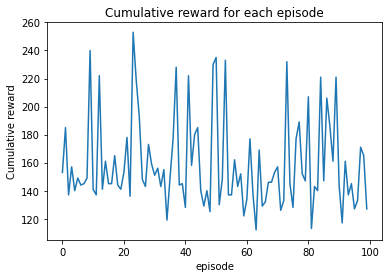

In [175]:
# episode_results = np.random.randint(150, 250, size=100)


plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [176]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 158.92
Is my agent good enough? False


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [149]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    #action = rand_policy_agent(observation)
    action = trained_policy(discretizer(*observation))
    observation, reward, done, info = env.step(action) 
    if done: 
      break;    
env.close()
show_video()